# Plotting decadal annual cycles of Arctic Regional ice volume

* **Description**: Plots historical and future annual cycles by decade and region
* **Input data**: Processed rufmod and cesm2-le regional total netcdf files
* **Output data**: Annual cycle plots in png format
* **Creator**: Alice DuVivier
* **Date**: August 2022

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import pandas as pd
from scipy.stats import ttest_ind


## Read in the processed data

This reads in pre-processed regional total ice area or volume for the Arctic.

Total Ice area = sum over lat/lon of (aice*tarea). Units = km2

Ice volume = sum over lat/lon of (hi*tarea). Units = km3


In [107]:
# list the variables to load
var_in = 'hi'

# 'aice', 'hi'

In [108]:
# set base directory where all data live
data_dir = '/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_5/fig_supp_ice_annual_cycle/'

# set file names
fin_le = 'CESM2-LE_all_transient_regional_total_'+var_in
fin_smooth = 'rufmod_all_transient_regional_total_'+var_in

In [109]:
ds_le = xr.open_dataset(data_dir+fin_le+'.nc',decode_times=True)
ds_smooth = xr.open_dataset(data_dir+fin_smooth+'.nc',decode_times=True)

In [110]:
# double check that year/month is not shifted incorrectly
ds_le.coords['time.month']
ds_smooth.coords['time.month']

<xarray.DataArray 'month' (time: 1032)>
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [111]:
# check what regions we have totals for
ds_le.region

# should match...
mask_in = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask']

In [112]:
print(ds_le.units)
print(ds_le.longname)

total_le = ds_le['regional_totals']
total_smooth = ds_smooth['regional_totals']

km^3
regional total ice volume


In [113]:
total_le

<xarray.DataArray 'regional_totals' (member_id: 50, time: 1032, region: 14)>
[722400 values with dtype=float64]
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) object 'r10i1181p1f1' ... 'r9i1301p1f1'
  * region     (region) object 'nh_mask' 'Lab_mask' ... 'CanCoast_mask'

In [114]:
data_le = total_le
data_smooth = total_smooth

In [115]:
#convert units
if var_in == 'aice':
    out_tag = 'ice_area'
    label = 'Ice Area'
    # convert to 1000000's of km3
    data_le = data_le/(1000000.0)
    data_smooth = data_smooth/(1000000.0)
    units = 'Total ice area ($10^{6}$ $km^{2}$)'
else:
    out_tag = 'ice_vol'
    label = 'Ice Volume'
    # convert to 1000's of km3
    data_le = data_le/(1000.0)
    data_smooth = data_smooth/(1000.0)
    units = 'Total ice volume ($10^{3}$ $km^{3}$)'

## Calculate the monthly means by decade

In [116]:
# make lists of both the months and decades we'll use
decades = list(range(2010,2100,10))
months = list(range(1,13,1))

In [117]:
#specify some arrays that will become coordinate arrays
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
decade_names = ['2010','2020','2030','2040','2050','2060','2070','2080','2090']

### CESM2-LE calculations

In [118]:
# For CESM2-LE: loop through months and decades to get all the annual cycles

# make numpy array to fill and specify dimensions we want
array_le = np.zeros([len(total_le.member_id),len(months),len(decades),len(total_le.region)])
#array_le.shape

# decade loop
for dec in decades:
    print('Calculating monthly means for '+str(dec))
    # need to specify which spot in the array we'll fill for the decade
    if dec == 2010:
        count = 0
    else: 
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    # subset the data for these years only but keep all months
    temp = data_le.isel(time=data_le.time.dt.year.isin([yy]))
    
    # month loop
    for mm in months:
        #print('Finding month '+str(mm))
        temp2 = temp.isel(time=temp.time.dt.month.isin([mm]))
        array_le[:,(mm-1),count,:] = temp2.mean(dim='time')

Calculating monthly means for 2010
Calculating monthly means for 2020
Calculating monthly means for 2030
Calculating monthly means for 2040
Calculating monthly means for 2050
Calculating monthly means for 2060
Calculating monthly means for 2070
Calculating monthly means for 2080
Calculating monthly means for 2090


In [119]:
# check the shape
print(array_le.shape)    

(50, 12, 9, 14)


In [120]:
# convert the numpy array to a xarray
decadal_means_le = xr.DataArray(array_le,dims=('member_id','month','decade','region'))

In [121]:
# assign some coordinate arrays
decadal_means_le['member_id'] = total_le.member_id
decadal_means_le['decade'] = np.array(decades)
decadal_means_le['month'] = np.array(months)
decadal_means_le['region'] = total_le.region

In [122]:
decadal_means_le.decade

<xarray.DataArray 'decade' (decade: 9)>
array([2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090])
Coordinates:
  * decade   (decade) int64 2010 2020 2030 2040 2050 2060 2070 2080 2090

### Rufmod experiments

In [123]:
# For Rufmod: loop through months and decades to get all the annual cycles
# NOTE that we had to change the loop for decades to only do 1950 onward as there isn't data before then for this expt.

# make numpy array to fill and specify dimensions we want
array_smooth = np.zeros([len(total_smooth.member_id),len(months),len(decades),len(total_smooth.region)])
#array_le.shape

# decade loop
for dec in decades:
    print('Calculating monthly means for '+str(dec))
    # need to specify which spot in the array we'll fill for the decade
    if dec == 2010:
        count = 0
    else: 
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    # subset the data for these years only but keep all months
    temp = data_smooth.isel(time=data_smooth.time.dt.year.isin([yy]))
    
    # month loop
    for mm in months:
        #print('Finding month '+str(mm))
        temp2 = temp.isel(time=temp.time.dt.month.isin([mm]))
        array_smooth[:,(mm-1),count,:] = temp2.mean(dim='time')

Calculating monthly means for 2010
Calculating monthly means for 2020
Calculating monthly means for 2030
Calculating monthly means for 2040
Calculating monthly means for 2050
Calculating monthly means for 2060
Calculating monthly means for 2070
Calculating monthly means for 2080
Calculating monthly means for 2090


In [124]:
# check the shape
print(array_smooth.shape)    

(5, 12, 9, 14)


In [125]:
# convert the numpy array to a xarray
decadal_means_smooth = xr.DataArray(array_smooth,dims=('member_id','month','decade','region'))

In [126]:
# assign some coordinate arrays
decadal_means_smooth['member_id'] = total_smooth.member_id
decadal_means_smooth['decade'] = np.array(decades)
decadal_means_smooth['month'] = np.array(months)
decadal_means_smooth['region'] = total_smooth.region

In [127]:
decadal_means_smooth.region

<xarray.DataArray 'region' (region: 14)>
array(['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask',
       'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask',
       'Okhotsk_mask', 'ArcOc_mask_and_Bar_mask', 'CanBeau_mask',
       'CanCoast_mask'], dtype=object)
Coordinates:
  * region   (region) object 'nh_mask' 'Lab_mask' ... 'CanCoast_mask'

## Grab by decade and get differences

In [128]:
# calculate means and statistical significance by decades
sigval1 = 0.05

In [129]:
## Could loop through, but won't for legacy reasons...

In [130]:
dec = 2020
temp1 = decadal_means_le.sel(decade=dec)
temp2 = decadal_means_smooth.sel(decade=dec)
tval,pval = ttest_ind(temp1,temp2,axis=0,equal_var=False)
# data to plot
le_data_2020 = temp1.mean(dim='member_id')
rufmod_data_2020 = temp2.mean(dim='member_id')
# data that's significant
le_data_2020_sig1 = le_data_2020.where(pval <= sigval1)
rufmod_data_2020_sig1 = rufmod_data_2020.where(pval <= sigval1)
# get differences
diff_2020 = rufmod_data_2020 - le_data_2020
pcnt_diff_2020 = 100*((rufmod_data_2020 - le_data_2020)/le_data_2020)
diff_2020_sig1 = diff_2020.where(pval <= sigval1)
pcnt_diff_2020_sig1 = pcnt_diff_2020.where(pval <= sigval1)

In [131]:
dec = 2030
temp1 = decadal_means_le.sel(decade=dec)
temp2 = decadal_means_smooth.sel(decade=dec)
tval,pval = ttest_ind(temp1,temp2,axis=0,equal_var=False)
# data to plot
le_data_2030 = temp1.mean(dim='member_id')
rufmod_data_2030 = temp2.mean(dim='member_id')
# data that's significant
le_data_2030_sig1 = le_data_2030.where(pval <= sigval1)
rufmod_data_2030_sig1 = rufmod_data_2030.where(pval <= sigval1)
# get differences
diff_2030 = rufmod_data_2030 - le_data_2030
pcnt_diff_2030 = 100*((rufmod_data_2030 - le_data_2030)/le_data_2030)
diff_2030_sig1 = diff_2030.where(pval <= sigval1)
pcnt_diff_2030_sig1 = pcnt_diff_2030.where(pval <= sigval1)

In [132]:
dec = 2040
temp1 = decadal_means_le.sel(decade=dec)
temp2 = decadal_means_smooth.sel(decade=dec)
tval,pval = ttest_ind(temp1,temp2,axis=0,equal_var=False)
# data to plot
le_data_2040 = temp1.mean(dim='member_id')
rufmod_data_2040 = temp2.mean(dim='member_id')
# data that's significant
le_data_2040_sig1 = le_data_2040.where(pval <= sigval1)
rufmod_data_2040_sig1 = rufmod_data_2040.where(pval <= sigval1)
# get differences
diff_2040 = rufmod_data_2040 - le_data_2040
pcnt_diff_2040 = 100*((rufmod_data_2040 - le_data_2040)/le_data_2040)
diff_2040_sig1 = diff_2040.where(pval <= sigval1)
pcnt_diff_2040_sig1 = pcnt_diff_2040.where(pval <= sigval1)

In [133]:
dec = 2050
temp1 = decadal_means_le.sel(decade=dec)
temp2 = decadal_means_smooth.sel(decade=dec)
tval,pval = ttest_ind(temp1,temp2,axis=0,equal_var=False)
# data to plot
le_data_2050 = temp1.mean(dim='member_id')
rufmod_data_2050 = temp2.mean(dim='member_id')
# data that's significant
le_data_2050_sig1 = le_data_2050.where(pval <= sigval1)
rufmod_data_2050_sig1 = rufmod_data_2050.where(pval <= sigval1)
# get differences
diff_2050 = rufmod_data_2050 - le_data_2050
pcnt_diff_2050 = 100*((rufmod_data_2050 - le_data_2050)/le_data_2050)
diff_2050_sig1 = diff_2050.where(pval <= sigval1)
pcnt_diff_2050_sig1 = pcnt_diff_2050.where(pval <= sigval1)

In [134]:
dec = 2060
temp1 = decadal_means_le.sel(decade=dec)
temp2 = decadal_means_smooth.sel(decade=dec)
tval,pval = ttest_ind(temp1,temp2,axis=0,equal_var=False)
# data to plot
le_data_2060 = temp1.mean(dim='member_id')
rufmod_data_2060 = temp2.mean(dim='member_id')
# data that's significant
le_data_2060_sig1 = le_data_2060.where(pval <= sigval1)
rufmod_data_2060_sig1 = rufmod_data_2060.where(pval <= sigval1)
# get differences
diff_2060 = rufmod_data_2060 - le_data_2060
pcnt_diff_2060 = 100*((rufmod_data_2060 - le_data_2060)/le_data_2060)
diff_2060_sig1 = diff_2060.where(pval <= sigval1)
pcnt_diff_2060_sig1 = pcnt_diff_2060.where(pval <= sigval1)

In [135]:
dec = 2070
temp1 = decadal_means_le.sel(decade=dec)
temp2 = decadal_means_smooth.sel(decade=dec)
tval,pval = ttest_ind(temp1,temp2,axis=0,equal_var=False)
# data to plot
le_data_2070 = temp1.mean(dim='member_id')
rufmod_data_2070 = temp2.mean(dim='member_id')
# data that's significant
le_data_2070_sig1 = le_data_2070.where(pval <= sigval1)
rufmod_data_2070_sig1 = rufmod_data_2070.where(pval <= sigval1)
# get differences
diff_2070 = rufmod_data_2070 - le_data_2070
pcnt_diff_2070 = 100*((rufmod_data_2070 - le_data_2070)/le_data_2070)
diff_2070_sig1 = diff_2070.where(pval <= sigval1)
pcnt_diff_2070_sig1 = pcnt_diff_2070.where(pval <= sigval1)

In [136]:
dec = 2080
temp1 = decadal_means_le.sel(decade=dec)
temp2 = decadal_means_smooth.sel(decade=dec)
tval,pval = ttest_ind(temp1,temp2,axis=0,equal_var=False)
# data to plot
le_data_2080 = temp1.mean(dim='member_id')
rufmod_data_2080 = temp2.mean(dim='member_id')
# data that's significant
le_data_2080_sig1 = le_data_2080.where(pval <= sigval1)
rufmod_data_2080_sig1 = rufmod_data_2080.where(pval <= sigval1)
# get differences
diff_2080 = rufmod_data_2080 - le_data_2080
pcnt_diff_2080 = 100*((rufmod_data_2080 - le_data_2080)/le_data_2080)
diff_2080_sig1 = diff_2080.where(pval <= sigval1)
pcnt_diff_2080_sig1 = pcnt_diff_2080.where(pval <= sigval1)

In [137]:
dec = 2090
temp1 = decadal_means_le.sel(decade=dec)
temp2 = decadal_means_smooth.sel(decade=dec)
tval,pval = ttest_ind(temp1,temp2,axis=0,equal_var=False)
# data to plot
le_data_2090 = temp1.mean(dim='member_id')
rufmod_data_2090 = temp2.mean(dim='member_id')
# data that's significant
le_data_2090_sig1 = le_data_2090.where(pval <= sigval1)
rufmod_data_2090_sig1 = rufmod_data_2090.where(pval <= sigval1)
# get differences
diff_2090 = rufmod_data_2090 - le_data_2090
pcnt_diff_2090 = 100*((rufmod_data_2090 - le_data_2090)/le_data_2090)
diff_2090_sig1 = diff_2090.where(pval <= sigval1)
pcnt_diff_2090_sig1 = pcnt_diff_2090.where(pval <= sigval1)

### Plotting!

In [138]:
mask_sub = ['ArcOc_mask']

In [139]:
# set x arrays against which to plot
xarr = months

Plotting decadal annual cycles for region ArcOc_mask


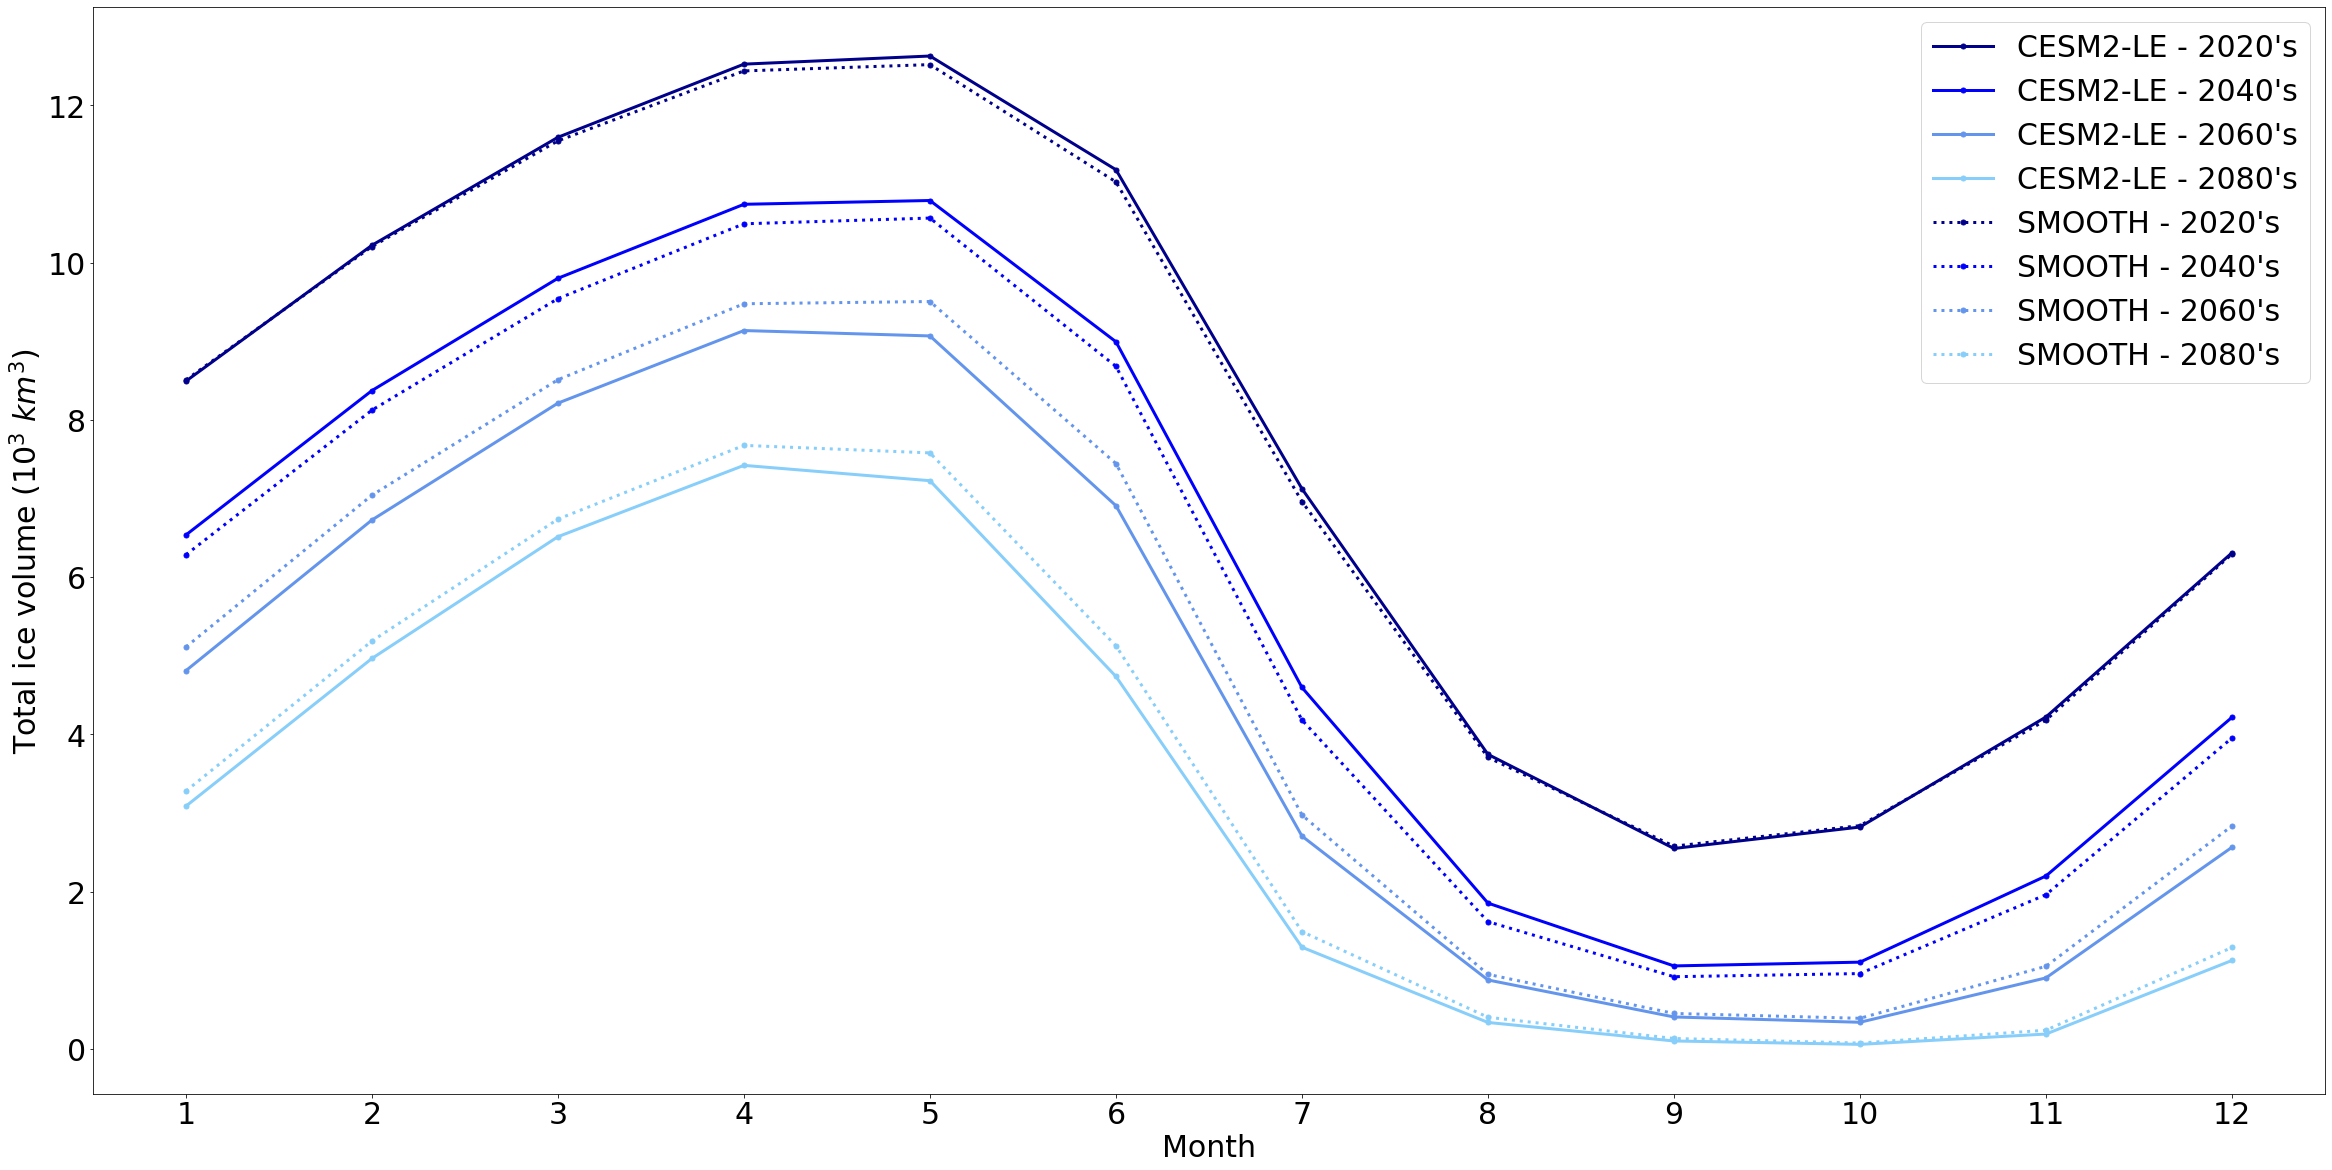

In [140]:
# Plot selected regional ice area with select decades
for reg in mask_sub:
    print('Plotting decadal annual cycles for region '+reg)
    # create figure
    fig = plt.figure(figsize=(40,20))
    fout = out_tag+'_'+reg+'_annual_cycle_transient'
    
    # now plot that data including significance
    ax = fig.add_subplot(1,1,1)
    # Plot data all
    ax.plot(xarr,le_data_2020.sel(region=reg),label="CESM2-LE - 2020's",color='darkblue',linestyle='-', linewidth=3, marker='o', markersize=5)
    ax.plot(xarr,le_data_2040.sel(region=reg),label="CESM2-LE - 2040's",color='blue',linestyle='-', linewidth=3, marker='o', markersize=5)
    ax.plot(xarr,le_data_2060.sel(region=reg),label="CESM2-LE - 2060's",color='cornflowerblue',linestyle='-', linewidth=3, marker='o', markersize=5)
    ax.plot(xarr,le_data_2080.sel(region=reg),label="CESM2-LE - 2080's",color='lightskyblue',linestyle='-', linewidth=3, marker='o', markersize=5)
    ax.plot(xarr,rufmod_data_2020.sel(region=reg),label="SMOOTH - 2020's",color='darkblue',linestyle=':', linewidth=3, marker='o', markersize=5)
    ax.plot(xarr,rufmod_data_2040.sel(region=reg),label="SMOOTH - 2040's",color='blue',linestyle=':', linewidth=3, marker='o', markersize=5)
    ax.plot(xarr,rufmod_data_2060.sel(region=reg),label="SMOOTH - 2060's",color='cornflowerblue',linestyle=':', linewidth=3, marker='o', markersize=5)
    ax.plot(xarr,rufmod_data_2080.sel(region=reg),label="SMOOTH - 2080's",color='lightskyblue',linestyle=':', linewidth=3, marker='o', markersize=5)

    # Plot the significant differences (95%) as bigger marker
    ax.plot(xarr,le_data_2020_sig1.sel(region=reg),color='darkblue',linestyle=' ', marker='o',markersize=20)
    ax.plot(xarr,le_data_2040_sig1.sel(region=reg),color='blue', linestyle=' ', marker='o',markersize=20)
    ax.plot(xarr,le_data_2060_sig1.sel(region=reg),color='cornflowerblue',linestyle=' ', marker='o', markersize=20)
    ax.plot(xarr,le_data_2080_sig1.sel(region=reg),color='lightskyblue',linestyle=' ',marker='o', markersize=20)
    ax.plot(xarr,rufmod_data_2020_sig1.sel(region=reg),color='darkblue',linestyle=' ', marker='o', markersize=20)
    ax.plot(xarr,rufmod_data_2040_sig1.sel(region=reg),color='blue',linestyle=' ', marker='o', markersize=20)
    ax.plot(xarr,rufmod_data_2060_sig1.sel(region=reg),color='cornflowerblue',linestyle=' ', marker='o', markersize=20)
    ax.plot(xarr,rufmod_data_2080_sig1.sel(region=reg),color='lightskyblue',linestyle=' ', marker='o', markersize=20)

    # set some labeling info
    plt.xlabel('Month',fontsize=30)
    plt.xticks(xarr,fontsize=30)
    plt.xlim([0.5,12.5])
    plt.ylabel(units,fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(ncol=1,fontsize=30)

    # Finalize figure and save
    #fig.suptitle(reg+' '+label+' Monthly Ensemble Mean by Decade',fontsize=20, y=0.92)  
    fig.subplots_adjust(hspace=0.3)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)